# CGIAR Crop Yield Prediction Challenge
### Zindi Competition
### Data Science Intensive Program Final Project
###### Sohana Singh

### Imports

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import itertools
from pylab import rcParams
import matplotlib
from matplotlib import pyplot as plt
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import show_hist
from sentinelsat import SentinelAPI
import geopandas as gpd
import folium 
import shapely
%matplotlib inline
#matplotlib.style.use('ggplot')

## Data

1. Read in names of data bands and training data

In [2]:
band_names = [l.strip() for l in open('bandnames.txt', 'r').readlines()]
#print(band_names)

In [3]:
train = pd.read_csv('Train.csv')
print(train.shape)
train.head(5)

(2977, 4)


,Field_ID,Year,Quality,Yield
0,MH2O0YH,2019,3,3.686
1,O9TURWL,2019,2,5.657
2,35AFSDD,2019,3,3.082
3,PM05EG9,2019,2,2.707
4,V7PZBCG,2019,2,2.679


The training data consists of the field id, year for which the satellite data was retrieved. The quality of the data is also indicated, with 3 being the best quality and 1 being poor quality. The crop yield is also available. The histogram of the distribution of the yield estimates indicate that the data is left-skewed, with fewer observations > 6. 

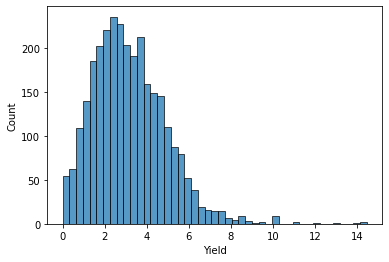

In [4]:
#Looking at the distribution of yield in the training set
sns.histplot(train['Yield'], palette="mako")
plt.show()

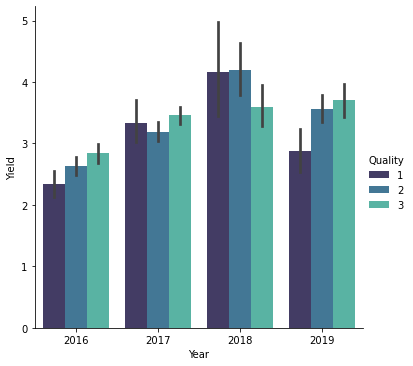

In [5]:
sns.catplot(data=train, kind="bar", x="Year", y="Yield", hue="Quality", palette="mako")

I chose to drop the data where the quality was equal to 1, as the challenge also indicated that there were no low quality fields (Quality = 1) in the test set. In some of the experiments, I also chose to drop data where yield was > 6.

In [6]:
train = train.drop(train[train.Quality == 1].index)
print(train.shape)
train.head(5)

(2552, 4)


,Field_ID,Year,Quality,Yield
0,MH2O0YH,2019,3,3.686
1,O9TURWL,2019,2,5.657
2,35AFSDD,2019,3,3.082
3,PM05EG9,2019,2,2.707
4,V7PZBCG,2019,2,2.679


In [7]:
train2 = train.drop(train[train.Yield >= 6].index)
print(train2.shape)
train2.head()

(2414, 4)


,Field_ID,Year,Quality,Yield
0,MH2O0YH,2019,3,3.686
1,O9TURWL,2019,2,5.657
2,35AFSDD,2019,3,3.082
3,PM05EG9,2019,2,2.707
4,V7PZBCG,2019,2,2.679


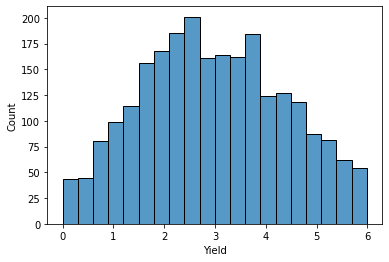

In [8]:
sns.histplot(train2['Yield'], palette="mako")
plt.show()

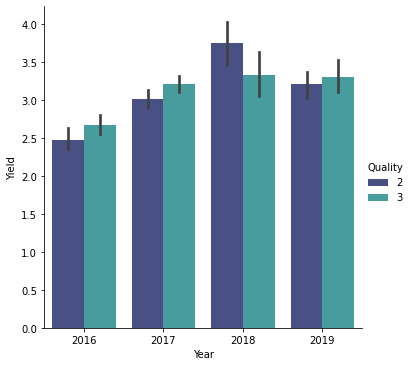

In [9]:
sns.catplot(data=train2, kind="bar", x="Year", y="Yield", hue="Quality", palette="mako")

Loading data/image_arrays_train/I9PVAD5.npy as an array
Array shape: (360, 41, 41)


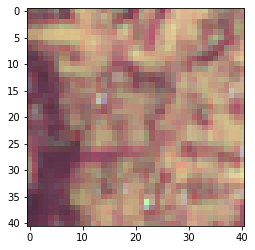

In [10]:
# Look at a sample:
fid = train2['Field_ID'].sample().values[0]
fn = f'data/image_arrays_train/{fid}.npy' # File name based on Field_ID
print(f'Loading {fn} as an array')
arr = np.load(fn) # Loading the data with numpy
print('Array shape:', arr.shape) # 360 bands, images 40 or 41px a side
rgb_jan = np.stack([arr[4], arr[3], arr[2]], axis=-1) # Combine three bands for viewing
rgb_jan = rgb_jan / np.max(rgb_jan) # Scale band values to (0, 1) for easy image display
plt.imshow(rgb_jan) # View with matplotlib

Loading data/image_arrays_train/BJN8BZA.npy as an array
Array shape: (360, 41, 41)


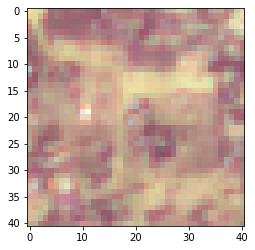

In [11]:
# Look at a sample:
fid = train2['Field_ID'].sample().values[0]
fn = f'data/image_arrays_train/{fid}.npy' # File name based on Field_ID
print(f'Loading {fn} as an array')
arr = np.load(fn) # Loading the data with numpy
print('Array shape:', arr.shape) # 360 bands, images 40 or 41px a side
rgb_feb = np.stack([arr[30 + 4], arr[30 + 3], arr[30 + 2]], axis=-1) # Combine three bands for viewing
rgb_feb = rgb_feb / np.max(rgb_feb) # Scale band values to (0, 1) for easy image display
plt.imshow(rgb_feb) # View with matplotlib

In [12]:
im2 = rio.plot.reshape_as_raster(rgb_jan)

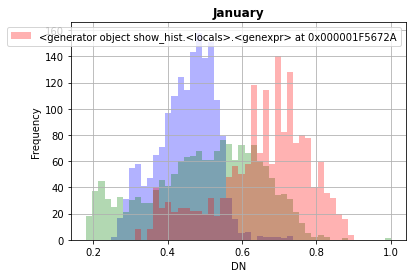

In [13]:
show_hist(im2, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="January") 

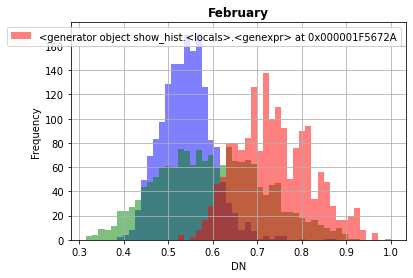

In [14]:
im3 = rio.plot.reshape_as_raster(rgb_feb)
show_hist(im3, bins =50, lw=0.0, masked = True, stacked=False, alpha=0.5, histtype='stepfilled', title="February")

In [2]:
# Look at a sample:
fid = train2['Field_ID'].sample().values[0]
fn = f'data/image_arrays_train/{fid}.npy' # File name based on Field_ID
print(f'Loading {fn} as an array')
arr = np.load(fn) # Loading the data with numpy
print('Array shape:', arr.shape) # 360 bands, images 40 or 41px a side
rgb_march = np.stack([arr[30*2 + 4], arr[30*2 + 3], arr[30*2 + 2]], axis=-1) # Combine three bands for viewing
rgb_march = rgb_march / np.max(rgb_march) # Scale band values to (0, 1) for easy image display
plt.imshow(rgb_march) # View with matplotlib

NameError: name 'train2' is not defined

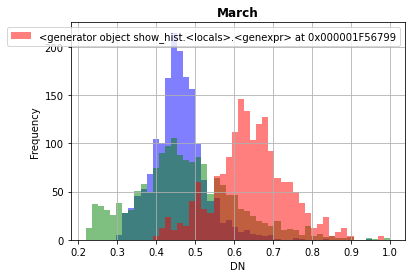

In [16]:
im4 = rio.plot.reshape_as_raster(rgb_march)
show_hist(im4, bins =50, lw=0.0, masked = True, stacked=False, alpha=0.5, histtype='stepfilled', title="March")

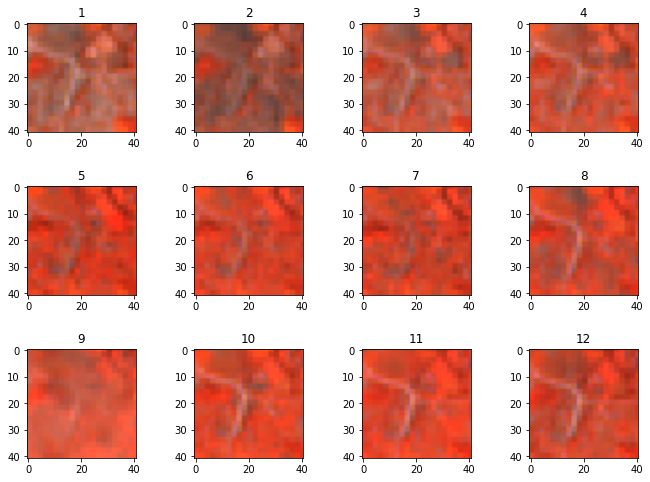

In [17]:
# View false colour images from each month in the year:
fig, axs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(12):
  rgb = np.stack([arr[i*30 + 8], arr[i*30 + 4], arr[i*30 + 3]], axis=-1) # False colour (band 8, 4 and 3)
  rgb = rgb / 4000 # Scaling consistently 
  axs[i].imshow(rgb.clip(0, 1))
  axs[i].set_title(str(i+1))

In [18]:
def process_im(fid, folder='data/image_arrays_train'):
  fn = f'{folder}/{fid}.npy'
  arr = np.load(fn)
  bands_of_interest = ['S2_B8','S2_B5', 'S2_B4', 'S2_B3', 'S2_B2', 'S2_B12' 'CLIM_pr', 'CLIM_soil', 'CLIM_tmmn', 'CLIM_tmmx']
  #bands_of_interest = ['S2_B2', 'S2_B3', 'S2_B4', 'S2_B5', 'S2_B6', 'S2_B7', 'S2_B8', 'S2_B8A', 'CLIM_pdsi',
                      #'CLIM_pr', 'CLIM_soil', 'CLIM_tmmn', 'CLIM_tmmx']
  #bands_of_interest = ['S2_B2', 'S2_B3', 'S2_B4', 'S2_B5', 'CLIM_pr', 'CLIM_soil', 'CLIM_tmmn', 'CLIM_tmmx']

  values = {}
  for month in range(12):
    bns = [str(month) + '_' + b for b in bands_of_interest] # Bands of interest for this month 
    idxs = np.where(np.isin(band_names, bns)) # Index of these bands
    vs = arr[idxs, 25, 25] # Sample the im at the center point
    nir = np.int64(vs[0][0])
    red = np.int64(vs[0][2])
    blue = np.int64(vs[0][4])
    SWIR = np.int64(vs[0][5])
    ndvi = (nir - red) / (nir + red)
    evi = (2.5 * (nir - red)) / ((nir + 6.0 * red - 7.5 * blue) + 1.0)
    ndwi = (nir - SWIR) / (nir + SWIR)
    
    for bn, v in zip(bns, vs[0]):
      values[bn] = v
    values[str(month) + '_ndvi'] = ndvi
    values[str(month) + '_evi'] = evi
    values[str(month) + '_ndwi'] = ndwi
  return values

# Example
#process_im('35AFSDD')

In [19]:
# Make a new DF with the sampled values from each field 
train_sampled = pd.DataFrame([process_im(fid) for fid in train2['Field_ID'].values])

# Add in the field ID and yield
train_sampled['Field_ID'] = train2['Field_ID'].values
train_sampled['Yield'] = train2['Yield'].values
train_sampled['Year'] = train2['Year'].values
train_sampled.head()
#train_sampled.to_csv("train_df.csv", index = False) # Saving train dataset

,0_S2_B8,0_S2_B5,0_S2_B4,0_S2_B3,0_S2_B2,0_S2_B12CLIM_pr,0_CLIM_soil,0_CLIM_tmmn,0_ndvi,0_evi,...,11_S2_B2,11_S2_B12CLIM_pr,11_CLIM_soil,11_CLIM_tmmn,11_ndvi,11_evi,11_ndwi,Field_ID,Yield,Year
0,848,871,870,1159,2443,287,112,285,-0.012806,0.004489,...,3436,215,100,267,0.222222,-0.033872,0.582119,MH2O0YH,3.686,2019
1,720,633,476,934,2075,287,108,288,0.204013,-0.050895,...,932,215,99,273,0.385554,-0.210743,0.520089,O9TURWL,5.657,2019
2,925,933,1182,1318,1812,278,109,288,-0.121974,0.115309,...,3771,289,100,274,-0.210843,0.208706,0.709839,35AFSDD,3.082,2019
3,776,719,989,951,2094,299,110,282,-0.120680,0.059206,...,7110,189,98,263,0.024127,-0.061455,0.940613,PM05EG9,2.707,2019
4,1013,949,919,1455,2854,427,161,320,0.048654,-0.015796,...,3401,1214,143,291,0.138427,-0.031549,-0.082962,V7PZBCG,2.679,2019


<AxesSubplot:xlabel='6_ndwi', ylabel='Yield'>

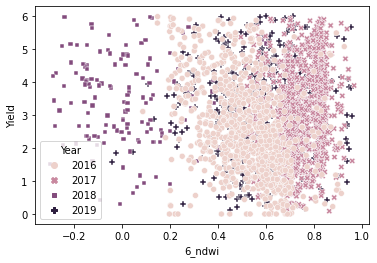

In [20]:
sns.scatterplot(data=train_sampled, x= "6_ndwi", y= "Yield" , hue = "Year", style = "Year")

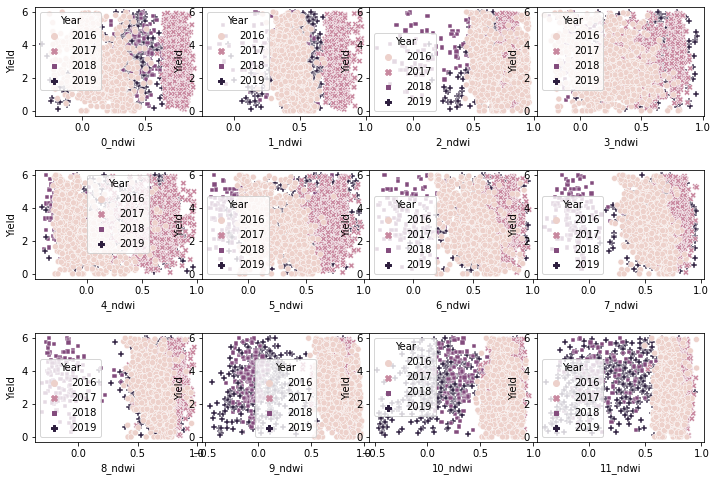

In [21]:
ndfig, ndaxs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
ndfig.subplots_adjust(hspace = .5, wspace=.001)
for month in range(12):
    col_name = str(month) + '_ndwi'
    ax_row = int(month / 4)
    ax_col = int(month % 4)
    sns.scatterplot(ax=ndaxs[ax_row, ax_col], data=train_sampled, x= col_name, y= "Yield" , hue = "Year", style = "Year")

In [22]:
ss = pd.read_csv('SampleSubmission.csv')
test_sampled = pd.DataFrame([process_im(fid, folder='data/image_arrays_test') for fid in ss['Field_ID'].values])
test_sampled.head()
test_cols = list(test_sampled.columns)
print(test_cols)
#test_sampled.to_csv("test_df.csv", index = False) # Saving test dataset

['0_S2_B8', '0_S2_B5', '0_S2_B4', '0_S2_B3', '0_S2_B2', '0_S2_B12CLIM_pr', '0_CLIM_soil', '0_CLIM_tmmn', '0_ndvi', '0_evi', '0_ndwi', '1_S2_B8', '1_S2_B5', '1_S2_B4', '1_S2_B3', '1_S2_B2', '1_S2_B12CLIM_pr', '1_CLIM_soil', '1_CLIM_tmmn', '1_ndvi', '1_evi', '1_ndwi', '2_S2_B8', '2_S2_B5', '2_S2_B4', '2_S2_B3', '2_S2_B2', '2_S2_B12CLIM_pr', '2_CLIM_soil', '2_CLIM_tmmn', '2_ndvi', '2_evi', '2_ndwi', '3_S2_B8', '3_S2_B5', '3_S2_B4', '3_S2_B3', '3_S2_B2', '3_S2_B12CLIM_pr', '3_CLIM_soil', '3_CLIM_tmmn', '3_ndvi', '3_evi', '3_ndwi', '4_S2_B8', '4_S2_B5', '4_S2_B4', '4_S2_B3', '4_S2_B2', '4_S2_B12CLIM_pr', '4_CLIM_soil', '4_CLIM_tmmn', '4_ndvi', '4_evi', '4_ndwi', '5_S2_B8', '5_S2_B5', '5_S2_B4', '5_S2_B3', '5_S2_B2', '5_S2_B12CLIM_pr', '5_CLIM_soil', '5_CLIM_tmmn', '5_ndvi', '5_evi', '5_ndwi', '6_S2_B8', '6_S2_B5', '6_S2_B4', '6_S2_B3', '6_S2_B2', '6_S2_B12CLIM_pr', '6_CLIM_soil', '6_CLIM_tmmn', '6_ndvi', '6_evi', '6_ndwi', '7_S2_B8', '7_S2_B5', '7_S2_B4', '7_S2_B3', '7_S2_B2', '7_S2_B12CLIM

In [23]:
X, y  = train_sampled[train_sampled.columns[:-3]], train_sampled['Yield']

In [24]:
X.head()

,0_S2_B8,0_S2_B5,0_S2_B4,0_S2_B3,0_S2_B2,0_S2_B12CLIM_pr,0_CLIM_soil,0_CLIM_tmmn,0_ndvi,0_evi,...,11_S2_B5,11_S2_B4,11_S2_B3,11_S2_B2,11_S2_B12CLIM_pr,11_CLIM_soil,11_CLIM_tmmn,11_ndvi,11_evi,11_ndwi
0,848,871,870,1159,2443,287,112,285,-0.012806,0.004489,...,840,518,1022,3436,215,100,267,0.222222,-0.033872,0.582119
1,720,633,476,934,2075,287,108,288,0.204013,-0.050895,...,486,302,392,932,215,99,273,0.385554,-0.210743,0.520089
2,925,933,1182,1318,1812,278,109,288,-0.121974,0.115309,...,2078,2613,2584,3771,289,100,274,-0.210843,0.208706,0.709839
3,776,719,989,951,2094,299,110,282,-0.120680,0.059206,...,5848,5885,6040,7110,189,98,263,0.024127,-0.061455,0.940613
4,1013,949,919,1455,2854,427,161,320,0.048654,-0.015796,...,987,778,1216,3401,1214,143,291,0.138427,-0.031549,-0.082962


In [25]:
cols = list(X.columns)
print(cols)

['0_S2_B8', '0_S2_B5', '0_S2_B4', '0_S2_B3', '0_S2_B2', '0_S2_B12CLIM_pr', '0_CLIM_soil', '0_CLIM_tmmn', '0_ndvi', '0_evi', '0_ndwi', '1_S2_B8', '1_S2_B5', '1_S2_B4', '1_S2_B3', '1_S2_B2', '1_S2_B12CLIM_pr', '1_CLIM_soil', '1_CLIM_tmmn', '1_ndvi', '1_evi', '1_ndwi', '2_S2_B8', '2_S2_B5', '2_S2_B4', '2_S2_B3', '2_S2_B2', '2_S2_B12CLIM_pr', '2_CLIM_soil', '2_CLIM_tmmn', '2_ndvi', '2_evi', '2_ndwi', '3_S2_B8', '3_S2_B5', '3_S2_B4', '3_S2_B3', '3_S2_B2', '3_S2_B12CLIM_pr', '3_CLIM_soil', '3_CLIM_tmmn', '3_ndvi', '3_evi', '3_ndwi', '4_S2_B8', '4_S2_B5', '4_S2_B4', '4_S2_B3', '4_S2_B2', '4_S2_B12CLIM_pr', '4_CLIM_soil', '4_CLIM_tmmn', '4_ndvi', '4_evi', '4_ndwi', '5_S2_B8', '5_S2_B5', '5_S2_B4', '5_S2_B3', '5_S2_B2', '5_S2_B12CLIM_pr', '5_CLIM_soil', '5_CLIM_tmmn', '5_ndvi', '5_evi', '5_ndwi', '6_S2_B8', '6_S2_B5', '6_S2_B4', '6_S2_B3', '6_S2_B2', '6_S2_B12CLIM_pr', '6_CLIM_soil', '6_CLIM_tmmn', '6_ndvi', '6_evi', '6_ndwi', '7_S2_B8', '7_S2_B5', '7_S2_B4', '7_S2_B3', '7_S2_B2', '7_S2_B12CLIM

In [26]:
mm_scaler = preprocessing.MinMaxScaler()
X = mm_scaler.fit_transform(X)
X = pd.DataFrame(X)
X.columns = cols
X.head()

,0_S2_B8,0_S2_B5,0_S2_B4,0_S2_B3,0_S2_B2,0_S2_B12CLIM_pr,0_CLIM_soil,0_CLIM_tmmn,0_ndvi,0_evi,...,11_S2_B5,11_S2_B4,11_S2_B3,11_S2_B2,11_S2_B12CLIM_pr,11_CLIM_soil,11_CLIM_tmmn,11_ndvi,11_evi,11_ndwi
0,0.067424,0.122957,0.177705,0.242164,0.413512,0.167854,0.264368,0.500000,0.403138,0.429256,...,0.055892,0.034474,0.092508,0.361163,0.084086,0.206186,0.402597,0.670417,0.585787,0.722164
1,0.020520,0.038380,0.048525,0.167931,0.316772,0.167854,0.218391,0.536585,0.746270,0.341984,...,0.006054,0.007592,0.012782,0.051453,0.084086,0.195876,0.480519,0.899502,0.484239,0.676219
2,0.095639,0.144989,0.280000,0.294622,0.247634,0.160728,0.229885,0.536585,0.230370,0.603885,...,0.230184,0.295208,0.290180,0.402597,0.119240,0.206186,0.493506,0.063011,0.725058,0.816765
3,0.041041,0.068941,0.216721,0.173540,0.321767,0.177356,0.241379,0.463415,0.232419,0.515479,...,0.760946,0.702427,0.727537,0.815584,0.071734,0.185567,0.350649,0.392574,0.569951,0.987697
4,0.127886,0.150675,0.193770,0.339822,0.521556,0.278702,0.827586,0.926829,0.500402,0.397292,...,0.076587,0.066833,0.117059,0.356834,0.558670,0.649485,0.714286,0.552888,0.587120,0.229545


In [27]:
mm_scaler = preprocessing.MinMaxScaler()
test_sampled_mm = mm_scaler.fit_transform(test_sampled)
test_sampled_mm= pd.DataFrame(test_sampled_mm)
test_sampled_mm.columns = test_cols
test_sampled_mm.head()

,0_S2_B8,0_S2_B5,0_S2_B4,0_S2_B3,0_S2_B2,0_S2_B12CLIM_pr,0_CLIM_soil,0_CLIM_tmmn,0_ndvi,0_evi,...,11_S2_B5,11_S2_B4,11_S2_B3,11_S2_B2,11_S2_B12CLIM_pr,11_CLIM_soil,11_CLIM_tmmn,11_ndvi,11_evi,11_ndwi
0,0.033637,0.051355,0.044315,0.094471,0.223756,0.229374,0.756410,0.840000,0.619409,0.364720,...,0.090486,0.061772,0.138988,0.312962,0.456113,0.677419,0.647059,0.617483,0.516980,0.392193
1,0.055280,0.070629,0.107156,0.113687,0.182474,0.229374,0.756410,0.840000,0.294174,0.516215,...,0.085020,0.065478,0.130435,0.337605,0.456113,0.677419,0.647059,0.568475,0.535663,0.379796
2,0.035291,0.047850,0.070347,0.092239,0.137267,0.220308,0.794872,0.853333,0.408889,0.434557,...,0.092308,0.041475,0.147541,0.412518,0.428683,0.725806,0.661765,0.712582,0.524855,0.390093
3,0.039151,0.058094,0.077249,0.104389,0.210840,0.220308,0.794872,0.853333,0.384058,0.443030,...,0.082591,0.069185,0.140770,0.299162,0.428683,0.725806,0.661765,0.562232,0.528067,0.411314
4,0.029639,0.045289,0.038140,0.095958,0.243890,0.220308,0.794872,0.853333,0.653779,0.363693,...,0.084211,0.058948,0.133999,0.359619,0.428683,0.725806,0.661765,0.612425,0.530159,0.403250


In [28]:
test_sampled_mm.shape, X.shape

((1055, 132), (2414, 132))

In [29]:
# Split the data

X_train, X_test, y_train, y_test = train_test_split(X, y)

Score: 1.2794766826464397


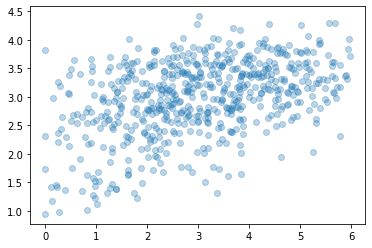

In [30]:
# Fit the model
RFmodel = RandomForestRegressor(random_state = 33)
RFmodel.fit(X_train, y_train)

# Score with RMSE
print('Score:', mean_squared_error(y_test, RFmodel.predict(X_test), squared=False))

# Plot pred vs actual for the test set:
plt.scatter(y_test, RFmodel.predict(X_test), alpha=0.3)

In [31]:
from sklearn.svm import SVR

In [32]:
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)

Score: 1.6993901230985593


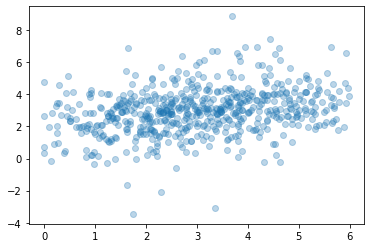

In [33]:
svr_rbf.fit(X_train, y_train)

# Score with RMSE
print('Score:', mean_squared_error(y_test, svr_rbf.predict(X_test), squared=False))

# Plot pred vs actual for the test set:
plt.scatter(y_test, svr_rbf.predict(X_test), alpha=0.3)

Score: 1.3317334433140025


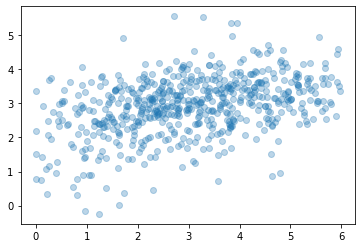

In [34]:
svr_lin.fit(X_train, y_train)

# Score with RMSE
print('Score:', mean_squared_error(y_test, svr_lin.predict(X_test), squared=False))

# Plot pred vs actual for the test set:
plt.scatter(y_test, svr_lin.predict(X_test), alpha=0.3)

Score: 1.6261844560676708


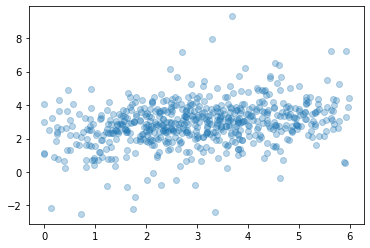

In [35]:
svr_poly.fit(X_train, y_train)

# Score with RMSE
print('Score:', mean_squared_error(y_test, svr_poly.predict(X_test), squared=False))

# Plot pred vs actual for the test set:
plt.scatter(y_test, svr_poly.predict(X_test), alpha=0.3)

In [36]:
# Get model predictions
preds = RFmodel.predict(test_sampled_mm)

# Store them in the submission dataframe and save
ss['Yield'] = preds
ss.to_csv('SubRF06a.csv', index=False)
ss.head()

,Field_ID,Yield
0,E9UZCEA,3.230030
1,1WGGS1Q,3.284572
2,EG2KXE2,3.423310
3,HC3GQXF,3.110462
4,7AK6GFK,3.298018


In [37]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(RFmodel.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 33, 'verbose': 0, 'warm_start': False}


In [38]:
# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# print(random_grid)
# {'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 400, 600, 800, 1000]}

{'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}

In [39]:
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [ ]:
# #taking a look at the optimal parameters
# rf_random.best_params_

Score: 1.267105793227118


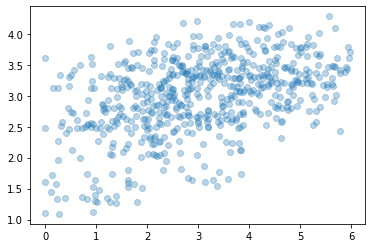

In [40]:
# Fit the model
RFmodel_tuned = RandomForestRegressor(random_state = 33, n_estimators = 555, min_samples_split=10,
                                     min_samples_leaf=2, max_features='sqrt', max_depth = 10, bootstrap=True)
RFmodel_tuned.fit(X_train, y_train)

# Score with RMSE
print('Score:', mean_squared_error(y_test, RFmodel_tuned.predict(X_test), squared=False))

# Plot pred vs actual for the test set:
plt.scatter(y_test, RFmodel_tuned.predict(X_test), alpha=0.3)

In [41]:
# Get model predictions
preds = RFmodel_tuned.predict(test_sampled_mm)

# Store them in the submission dataframe and save
ss['Yield'] = preds
ss.to_csv('SubRF06b_tuned.csv', index=False)
ss.head()

,Field_ID,Yield
0,E9UZCEA,3.199955
1,1WGGS1Q,3.233801
2,EG2KXE2,3.292333
3,HC3GQXF,3.178341
4,7AK6GFK,3.210130


In [1]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [45]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

[20:59:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
Score: 1.267105793227118


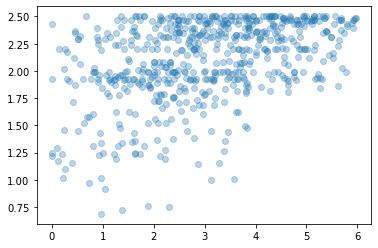

In [47]:
xg_reg.fit(X_train, y_train)
# Score with RMSE
print('Score:', mean_squared_error(y_test, xg_reg_fit.predict(X_test), squared=False))

# Plot pred vs actual for the test set:
plt.scatter(y_test, xg_reg.predict(X_test), alpha=0.3)

In [48]:
rmse = np.sqrt(mean_squared_error(y_test, xg_reg.predict(X_test)))
print("RMSE: %f" % (rmse))

RMSE: 1.588886


In [51]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [52]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[21:05:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[21:05:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[21:05:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


In [53]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,2.624138,0.024366,2.628080,0.054993
1,2.427739,0.022163,2.435757,0.054877
2,2.254499,0.020816,2.266704,0.053325
3,2.101964,0.019419,2.119240,0.055060
4,1.968431,0.017746,1.991895,0.056170


In [54]:
print((cv_results["test-rmse-mean"]).tail(1))

49    1.281844
Name: test-rmse-mean, dtype: float64


In [55]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[21:07:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


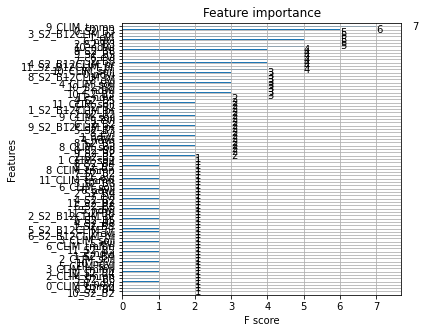

In [57]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

In [58]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [62]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

num_boost_round = 999

In [63]:
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=9, min_child_weight=5
[21:21:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[21:21:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[21:21:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[21:21:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[21:21:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 1.0728382 for 36 rounds
CV with max_depth=9, min_child_weight=6
[21:21

	MAE 1.0725656000000001 for 26 rounds
Best params: 10, 6, MAE: 1.0709123999999999


In [76]:
from sklearn.model_selection import GridSearchCV

In [77]:
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)
    return gsearch.best_params_

In [78]:
hyperParameterTuning(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 25.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 45.0min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 56.5min finished


{'colsample_bytree': 0.5,
 'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_weight': 5,
 'n_estimators': 500,
 'objective': 'reg:squarederror',
 'subsample': 0.5}

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.01,
                max_depth = 3, min_child_weight = 5, subsample = 0.5, alpha = 10, n_estimators = 500)